In [35]:
#importing 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score,precision_score,accuracy_score,f1_score
from imblearn.over_sampling import SMOTE
from geopy.distance import geodesic 
import matplotlib.pyplot as plt
import joblib

In [36]:
#read data (df)

df=pd.read_csv('Dataset.csv')
df.head()
print(df.isnull().sum())# so no null values


Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


In [37]:
#convert date and time
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
df["hour"] = df["trans_date_trans_time"].dt.hour
df["day"] = df["trans_date_trans_time"].dt.day
df["month"] = df["trans_date_trans_time"].dt.month


In [38]:
#drop unnessary columns

columns_to_drop = ["Unnamed: 0","trans_date_trans_time", "trans_num", "first", "last", "city_pop", "dob","street","city","state","job","merchant","unix_time"]
df=df.drop(columns=columns_to_drop)
df.head()

,cc_num,category,amt,gender,zip,lat,long,merch_lat,merch_long,is_fraud,hour,day,month
0,2703186189652095,misc_net,4.97,F,28654,36.0788,-81.1781,36.011293,-82.048315,0,0,1,1
1,630423337322,grocery_pos,107.23,F,99160,48.8878,-118.2105,49.159047,-118.186462,0,0,1,1
2,38859492057661,entertainment,220.11,M,83252,42.1808,-112.2620,43.150704,-112.154481,0,0,1,1
3,3534093764340240,gas_transport,45.00,M,59632,46.2306,-112.1138,47.034331,-112.561071,0,0,1,1
4,375534208663984,misc_pos,41.96,M,24433,38.4207,-79.4629,38.674999,-78.632459,0,0,1,1


In [39]:
#label encoding
categorical_cols = ['category', 'gender']
encoders={}
for col in categorical_cols:
    encoders[col]=LabelEncoder()
    df[col]=encoders[col].fit_transform(df[col])
df.head()

,cc_num,category,amt,gender,zip,lat,long,merch_lat,merch_long,is_fraud,hour,day,month
0,2703186189652095,8,4.97,0,28654,36.0788,-81.1781,36.011293,-82.048315,0,0,1,1
1,630423337322,4,107.23,0,99160,48.8878,-118.2105,49.159047,-118.186462,0,0,1,1
2,38859492057661,0,220.11,1,83252,42.1808,-112.2620,43.150704,-112.154481,0,0,1,1
3,3534093764340240,2,45.00,1,59632,46.2306,-112.1138,47.034331,-112.561071,0,0,1,1
4,375534208663984,9,41.96,1,24433,38.4207,-79.4629,38.674999,-78.632459,0,0,1,1


In [40]:
#calculate distence between customer and merchant
def haversine(lat1,lon1,lat2,lon2):
    return np.array([geodesic((a,b),(c,d)).km for a,b,c,d in zip (lat1,lon1,lat2,lon2)])
df['distance']=haversine(df['lat'],df['long'],df['merch_lat'],df['merch_long'])
df.head()

,cc_num,category,amt,gender,zip,lat,long,merch_lat,merch_long,is_fraud,hour,day,month,distance
0,2703186189652095,8,4.97,0,28654,36.0788,-81.1781,36.011293,-82.048315,0,0,1,1,78.773821
1,630423337322,4,107.23,0,99160,48.8878,-118.2105,49.159047,-118.186462,0,0,1,1,30.216618
2,38859492057661,0,220.11,1,83252,42.1808,-112.2620,43.150704,-112.154481,0,0,1,1,108.102912
3,3534093764340240,2,45.00,1,59632,46.2306,-112.1138,47.034331,-112.561071,0,0,1,1,95.685115
4,375534208663984,9,41.96,1,24433,38.4207,-79.4629,38.674999,-78.632459,0,0,1,1,77.702395


In [41]:
#split to feature and target
X = df.drop(columns=["is_fraud"])  
y = df["is_fraud"]                

In [42]:

class_distribution = df['is_fraud'].value_counts()
print (class_distribution)  #so data is imbalanced

# Oversample minority class (1) to 50,000 using SMOTE without duplicationnn
smote = SMOTE(sampling_strategy={1: 50000}, random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Undersample majority class (0) to 50,000
undersampler = RandomUnderSampler(sampling_strategy={0: 50000}, random_state=42)
X_balanced, y_balanced = undersampler.fit_resample(X_smote, y_smote)


print( Counter(y_balanced)) #after solve imbalancing



is_fraud
0    1842743
1       9651
Name: count, dtype: int64
Counter({0: 50000, 1: 50000})


In [43]:
#split into train and test set

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

In [44]:
#Model Training

#XGBOOST Model
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
xgb.fit(X_train, y_train)

#Random Forest Model
rfm = RandomForestClassifier(random_state=42)
rfm.fit(X_train, y_train)

#Logistic Regression Model
#scalling important for logistic regressionnnnn!
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred_log = log_reg.predict(X_test_scaled)
y_pred_rfm = rfm.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

In [45]:
#Evaluation
results = []


models = {
    "Logistic Regression": y_pred_log,
    "Random Forest": y_pred_rfm,
    "XGBoost": y_pred_xgb
}


for model_name, y_pred_model in models.items():
    results.append({
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred_model),
        "Precision": precision_score(y_test, y_pred_model),
        "Recall": recall_score(y_test, y_pred_model),
        "F1 Score": f1_score(y_test, y_pred_model)
    })


results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy  Precision  Recall  F1 Score
0  Logistic Regression    0.8630   0.935252  0.7800  0.850600
1        Random Forest    0.9612   0.974876  0.9468  0.960633
2              XGBoost    0.9613   0.971773  0.9502  0.960866


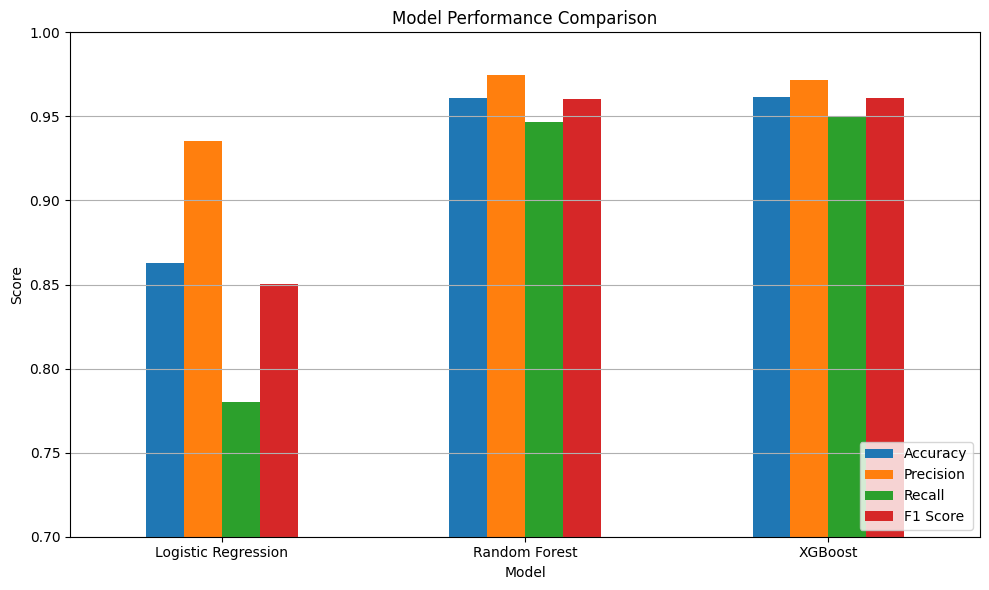

In [46]:


results_df.set_index("Model").plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# joblib.dump(xgb,"X_G_Boost.jb")
# joblib.dump(encoders,"label_encoder.jb")

['label_encoder.jb']